<a href="https://colab.research.google.com/github/snehasharma0807/eeg-epilepsy/blob/main/oct16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Imports
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#install and import packages
!pip install ipython-autotime
%load_ext autotime
# !pip install mne
import tensorflow as tf
from tensorflow import keras
# import os
# import mne
# from mne import create_info
# from mne.viz import plot_topomap
import numpy as np
import torch
import io
import matplotlib.pyplot as plt


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
time: 9.04 s (started: 2023-10-16 23:27:08 +00:00)


In [ ]:
# @title Preprocessing Data: Functions
def getTimeFreqTopoData(EEG):
  times = []
  sec_increment = 10 * 60  # 10 minutes
  trange = np.arange(EEG.times[0], EEG.times[-1] + sec_increment, sec_increment)
  for i in np.arange(len(trange) - 1):
    times.append((trange[i], trange[i + 1]))

  bands = []
  frange = np.arange(80, 260, 10)  # Adjusted frequency range
  for i in np.arange(len(frange) - 1):
    bands.append((frange[i], frange[i + 1]))

  tf_topodata = []
  for t in times:
    print(t[0], '-', t[1])
    spectrum = EEG.compute_psd(tmin=t[0], tmax=t[1])
    freq_topodata = getTopoData(spectrum, bands)
    tf_topodata.append(freq_topodata)
  tf_topodata = np.stack(tf_topodata)
  return tf_topodata



def getTopoData(spectrum, bands):
  data = []
  for band in bands:
    data.append(getTopoBandData(spectrum, band))
  data = np.stack(data)
  return data

def getTopoBandData(spectrum, band):
  fig, ax1 = plt.subplots()
  fig.set_size_inches(2,2)
  spectrum.plot_topomap(axes=ax1, bands={'':band}, dB=True, cmap='gray', contours=0, outlines='head', sensors=False);
  fig.get_axes()[1].remove() #remove colorbar
  fig.get_axes()[0].set_title(None)

  with io.BytesIO() as buff:
    fig.savefig(buff, format='raw')
    buff.seek(0)
    data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
  w, h = fig.canvas.get_width_height()
  im = data.reshape((int(h), int(w), -1))
  im = im[30:155, 25:150, 0]
  plt.close()
  return im

time: 1.47 ms (started: 2023-08-11 01:53:23 +00:00)


In [ ]:
# @title Preprocessing Data
subjects = ["24", "25", "26", "27", "28", "29", "30"]

for subj in subjects:
  #loading data
  sample_data_folder =("/content/drive/MyDrive/projectcode")
  sample_data_raw_file = os.path.join(sample_data_folder,'sub-'+ subj + '_ses-01_task-hfo_eeg.edf')
  raw = mne.io.read_raw_edf(sample_data_raw_file,preload = True)
  raw.load_data()

  #check channels
  print(raw.info.ch_names)
  raw.drop_channels(["A1", "A2", "Cz2", 'T1', 'T2'], on_missing = 'ignore')
  print(raw.info.ch_names)

  #resample data to 500 hz
  resampled = raw.resample(500)

  data = resampled.get_data()
  info = create_info(ch_names=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'], sfreq=500, ch_types='eeg')
  info.set_montage('standard_1020')

  EEG = mne.io.RawArray(data, info)

  tf_topodata = getTimeFreqTopoData(EEG)  # output shape = [# time windows X # freq bands X # vert pixels X # horz pixels]
  print(tf_topodata.shape)
  output_directory = "/content/drive/MyDrive/projectcode/newtensors/"
  tftopo_fileName =str(subj) + '_tf_topodata.tensor'
  output = os.path.join(output_directory, tftopo_fileName)
  torch.save(tf_topodata, output)
  EEG = None
  tf_topodata = None
  raw = None
  resampled = None

  print("Done with " + subj)

In [2]:
# @title Getting Data Ready for ML
import torch

def getTensorFromFile(subject):
  tftopo_fileName = "/content/drive/MyDrive/projectcode/newtensors/"+subject+"_tf_topodata.tensor"
  tf_topodata = torch.load(tftopo_fileName)
  return tf_topodata


subjects = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"]

tensors = [getTensorFromFile(subj) for subj in subjects]
tensors[12], tensors[19], tensors[29] = tensors[12][:-1, :, :, :], tensors[19][:-1, :, :, :], tensors[29][:-1, :, :, :]

#right shape
tensors = [np.transpose(t, (0, 2, 3, 1)) for t in tensors]

#normalize data
tensors = [t.astype("float32")/255.0 for t in tensors]

#convert into correct shape
data = [array[:, 0:, :, :] for array in tensors]
data = np.concatenate(data, axis=0) #np.stack
print(data.shape)

def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

normalized_data = normalize_data(data)
print(normalized_data.shape)

(535, 125, 125, 17)
(535, 125, 125, 17)
time: 42.9 s (started: 2023-10-16 23:27:28 +00:00)


In [ ]:
# @title Autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

input = Input(shape = (125,125,17))
# Encoder layers
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(input)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
print(encoder.shape)

# Decoder layers
decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
# Add a cropping layer to match dimensions
cropped = Cropping2D(cropping=((1, 2), (1, 2)))(decoder)  # Adjust cropping values as needed
# Output layer
output = Conv2D(17, (3, 3), activation='sigmoid', padding='same')(cropped)

# Choose an appropriate loss function
loss_function = MeanSquaredError()
auto_encoder = Model(inputs=input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
auto_encoder.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', 'mse'])

auto_encoder.fit(normalized_data, normalized_data, epochs=5, batch_size=32)

# auto_encoder.save("/content/drive/MyDrive/projectcode/weights/oct15-7:30pm.pb")

(None, 32, 32, 16)
Epoch 1/5
17/17 [==============================] - 72s 4s/step - loss: 0.1060 - accuracy: 0.1695 - mse: 0.1060
Epoch 2/5
17/17 [==============================] - 69s 4s/step - loss: 0.0575 - accuracy: 0.1368 - mse: 0.0575
Epoch 3/5
17/17 [==============================] - 71s 4s/step - loss: 0.0277 - accuracy: 0.1474 - mse: 0.0277
Epoch 4/5
17/17 [==============================] - 70s 4s/step - loss: 0.0202 - accuracy: 0.1772 - mse: 0.0202
Epoch 5/5
17/17 [==============================] - 71s 4s/step - loss: 0.0165 - accuracy: 0.1917 - mse: 0.0165


time: 6min 29s (started: 2023-10-16 02:31:25 +00:00)


In [3]:
# @title Load Saved Autoencoder
auto_encoder = tf.keras.models.load_model("/content/drive/MyDrive/projectcode/weights/oct14-2.pb")
auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 125, 17)]    0         
                                                                 
 conv2d (Conv2D)             (None, 125, 125, 8)       16464     
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 2)       402       
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 8)       408       
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 17)      16473     
                                                                 
Total params: 33747 (131.82 KB)
Trainable params: 33747 (131.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 5.62 s (started: 

In [4]:
out = auto_encoder.predict(normalized_data)

17/17 [==============================] - 30s 2s/step
time: 41.9 s (started: 2023-10-16 23:28:31 +00:00)


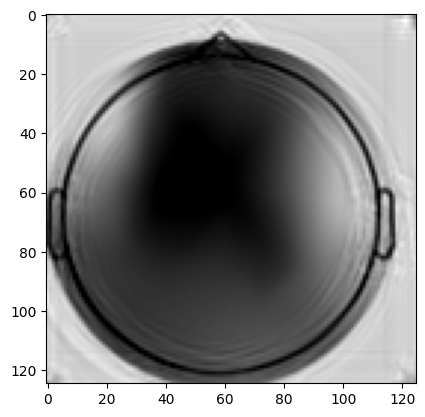

time: 342 ms (started: 2023-10-16 23:29:17 +00:00)


In [5]:
plt.imshow(out[0,:,:,10], "gray")

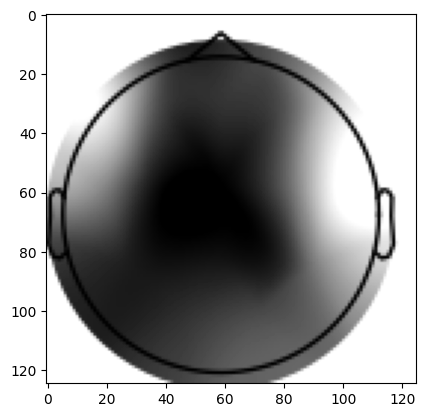

time: 381 ms (started: 2023-10-16 02:57:39 +00:00)


In [ ]:
plt.imshow(normalized_data[0,:,:,10], "gray")

In [9]:
from keras import backend as K

K.clear_session()
input = auto_encoder.get_layer("input_1")(normalized_data[0,:,:,:])
input = K.reshape(input,(1, 125, 125,17))
print(input.shape)
conv2d = auto_encoder.get_layer("conv2d")(input)
conv2d = K.reshape(conv2d,(1, 125, 125, 8))
max_pooling2d = auto_encoder.get_layer("conv2d_1")(conv2d)
max_pooling2d = K.reshape(max_pooling2d,(1, 125, 125, 2))
# conv2d_1 = auto_encoder.get_layer("conv2d_2")(max_pooling2d)
# conv2d_1 = K.reshape(conv2d_1,(1, 63, 63, 32))
# max_pooling2d_1 = auto_encoder.get_layer("conv2d_3")(conv2d_1)
# max_pooling2d_1 = K.reshape(max_pooling2d_1,(1, 32, 32, 32))


# # last_layer_outputs = tf.keras.Model(input, seq_model.layers[-3].output)
auto_encoder.summary()

(1, 125, 125, 17)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 125, 17)]    0         
                                                                 
 conv2d (Conv2D)             (None, 125, 125, 8)       16464     
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 2)       402       
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 8)       408       
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 17)      16473     
                                                                 
Total params: 33747 (131.82 KB)
Trainable params: 33747 (131.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time:

(1, 125, 125, 2)
0.0
1.8692961


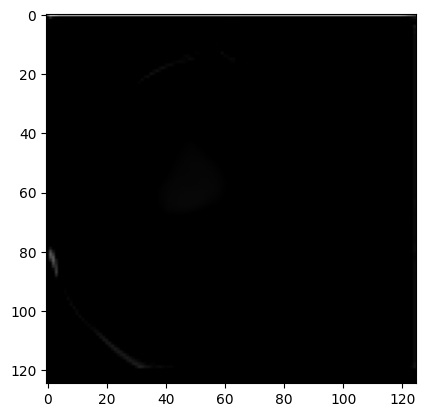

time: 830 ms (started: 2023-10-16 23:37:11 +00:00)


In [17]:
plt.imshow(max_pooling2d[0, :, :, 1], "gray")
print(max_pooling2d.shape)
print(np.array(max_pooling2d[0, :, :, 1]).min())
print(np.array(max_pooling2d[0, :, :, 1]).max())

In [ ]:
# @title Feature Extraction
encoded_features = auto_encoder.predict(reduced_data)
print(encoded_features.shape)

In [ ]:
# @title Feature Extraction with CNN
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# load vgg model
base_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(125, 125, 3))

# freeze weights of pretrained layers
for layer in base_vgg.layers:
  layer.trainable = False

x = Flatten()(base_vgg.output)
x = Dense(2048, activation='relu')(x)
x = Dense(1028, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)


feature_extractor = Model(inputs=base_vgg.input, outputs=x)
feature_extractor.compile(optimizer='adam', loss='mse')

# extract features
features = feature_extractor.predict(reduced_data)

print(features.shape)

17/17 [==============================] - 127s 8s/step
(535, 128)
time: 2min 23s (started: 2023-09-24 21:43:02 +00:00)


In [ ]:
# @title KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=20, random_state=0)
features = out.reshape(out.shape[0], -1)
cluster_assignments = kmeans.fit_predict(features)
print(cluster_assignments.shape)


# x = cluster_assignments[:324]
# x = x.reshape((18, 18))
# print(x)

# x = cluster_assignments[324:337]
# x = x.reshape((1, 13))
# print(x)

# x = cluster_assignments[337:]
# x = x.reshape((11, 18))
# print(x)


x = np.where(cluster_assignments == 0)[0]
print(x.shape)
x = np.where(cluster_assignments == 1)[0]
print(x.shape)
x = np.where(cluster_assignments == 2)[0]
print(x.shape)

(535,)
(75,)
(205,)
(255,)
time: 2min 37s (started: 2023-10-16 02:59:58 +00:00)


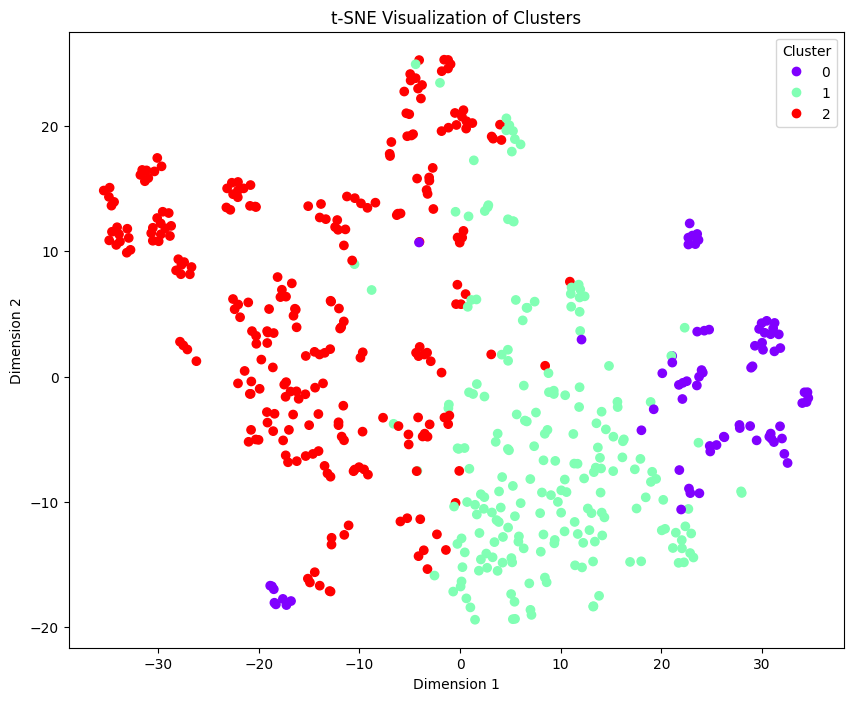

time: 18.8 s (started: 2023-10-16 03:03:53 +00:00)


In [ ]:
# @title Visualize Clusters with t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'features' are your extracted features and 'cluster_assignments' are the cluster labels

tsne = TSNE(n_components=2, random_state=0)  # Use n_components=2 for 2D visualization
embedded_data = tsne.fit_transform(features)

# Create a scatter plot in 2D with cluster coloring
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=cluster_assignments, cmap='rainbow')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Add colorbar
legend = plt.legend(*scatter.legend_elements(), title='Cluster')

plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
<ipython-input-58-1ae8b24c6d1d>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 4))


<Figure size 1000x800 with 0 Axes>

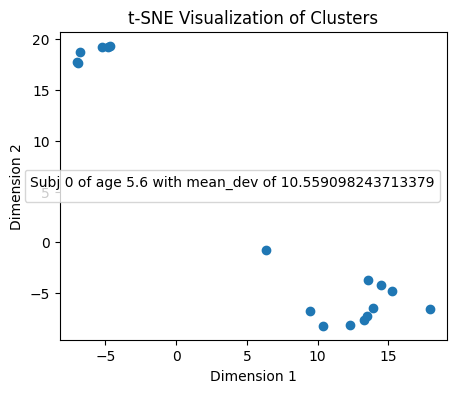

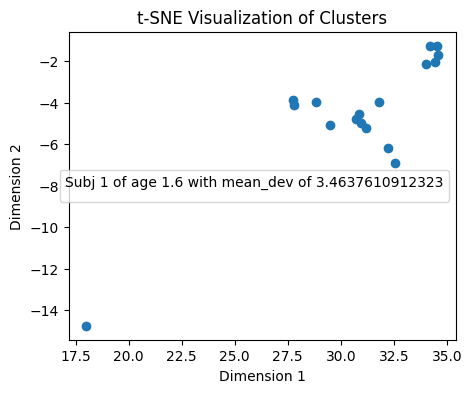

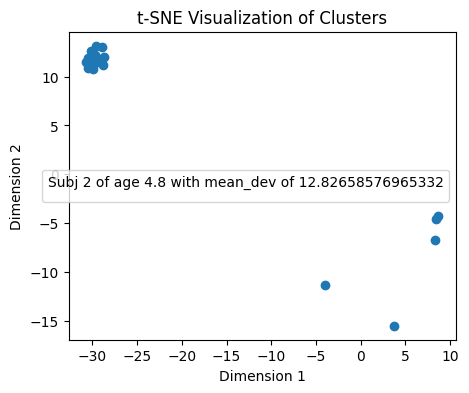

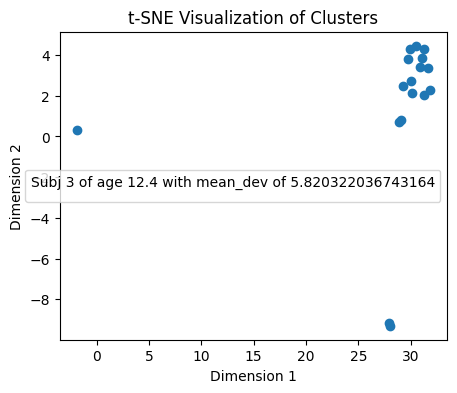

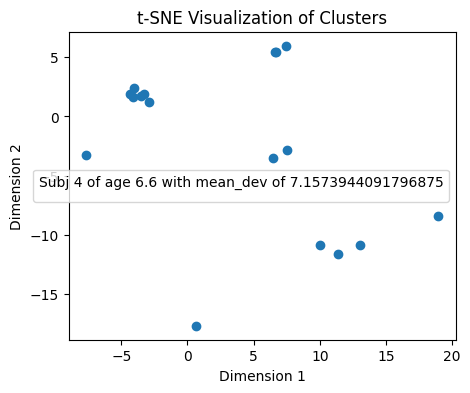

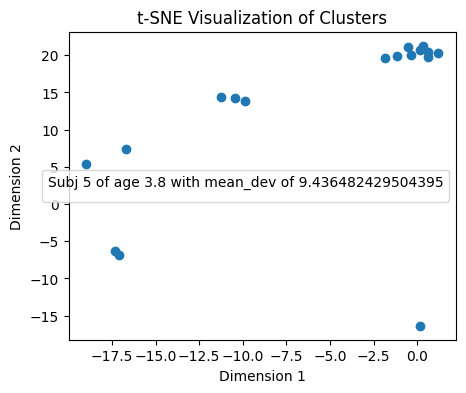

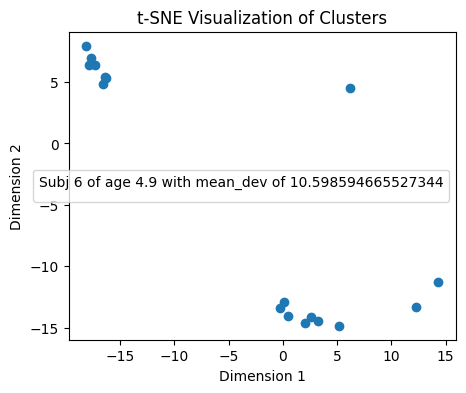

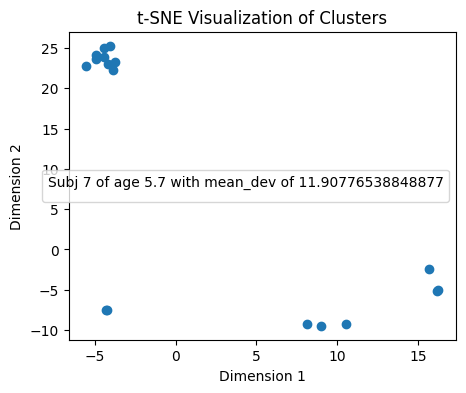

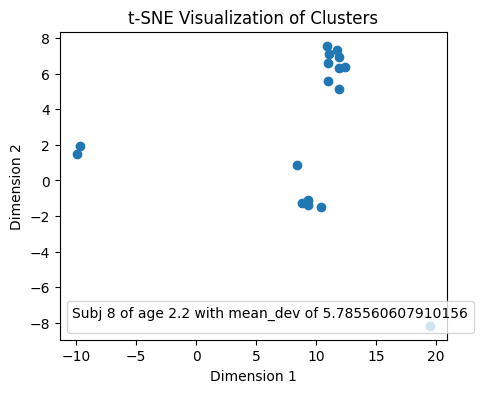

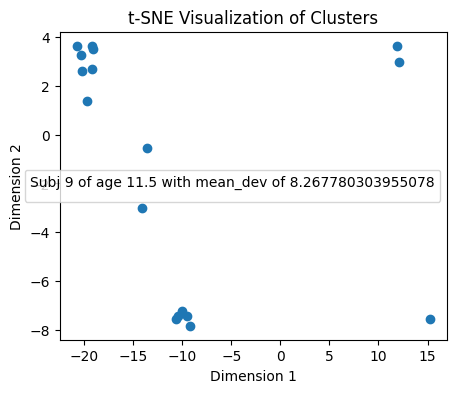

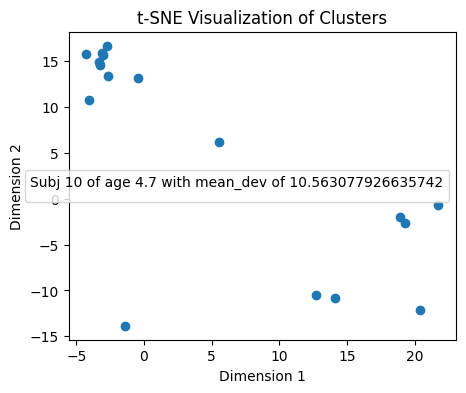

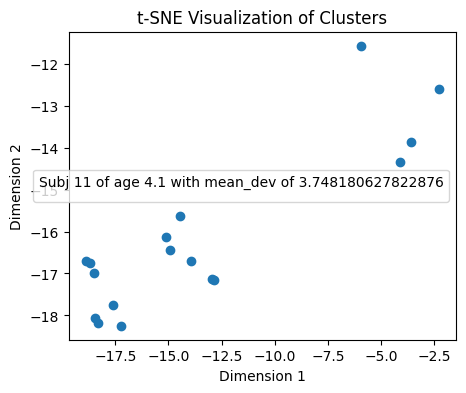

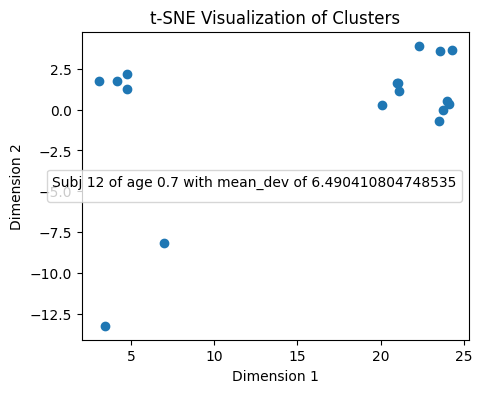

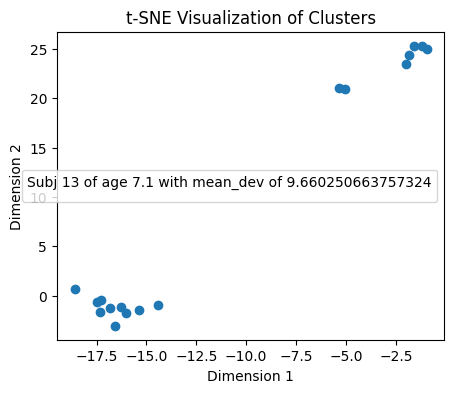

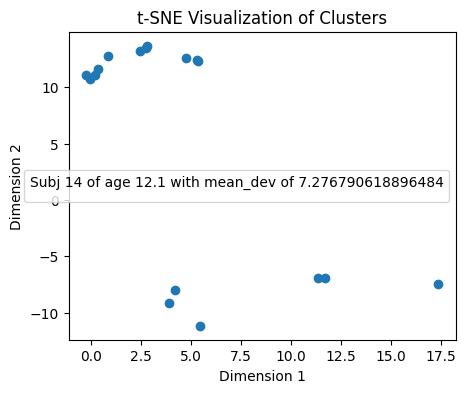

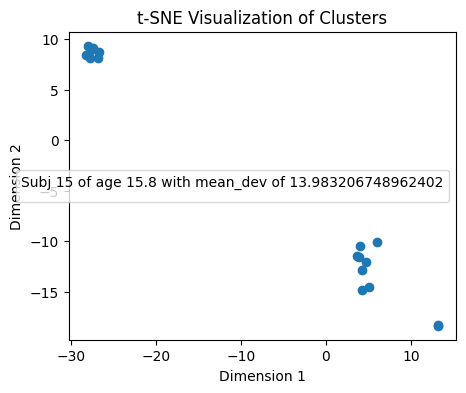

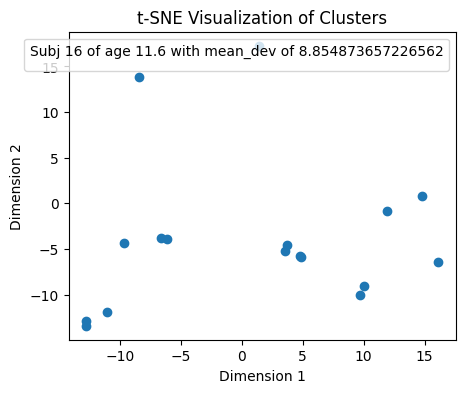

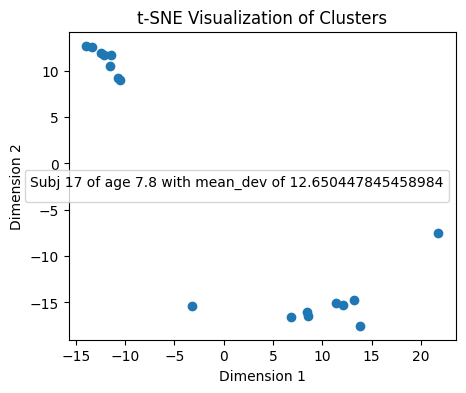

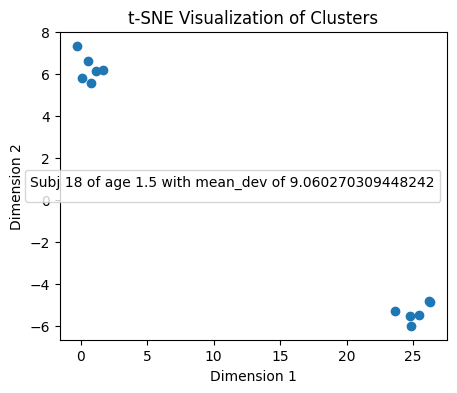

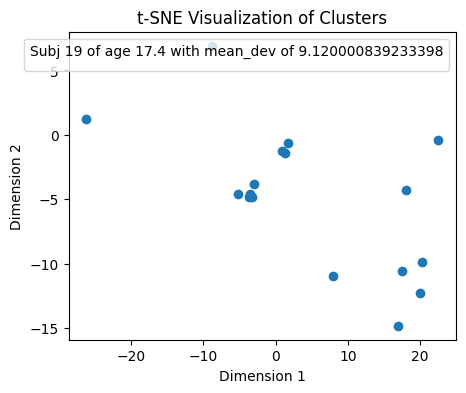

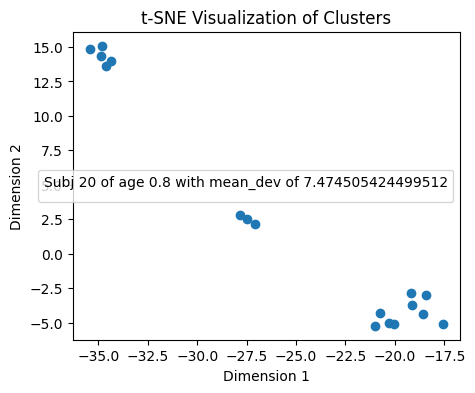

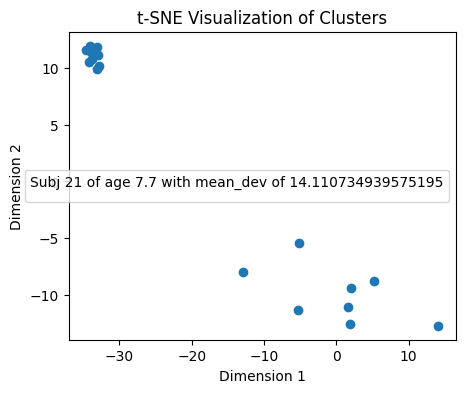

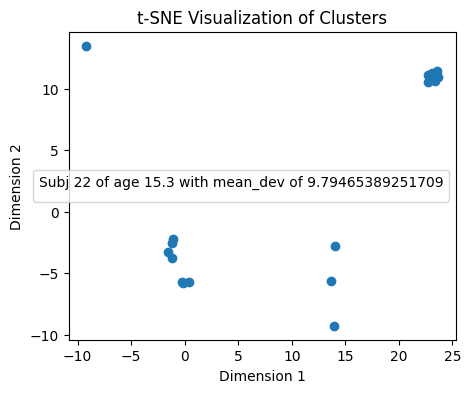

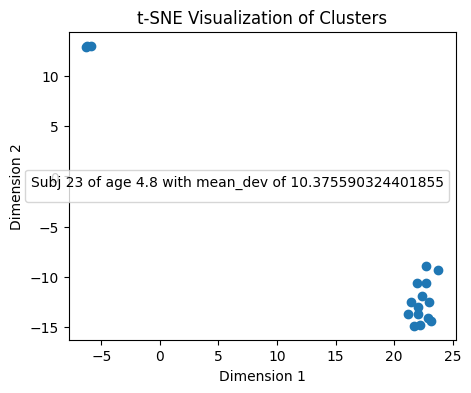

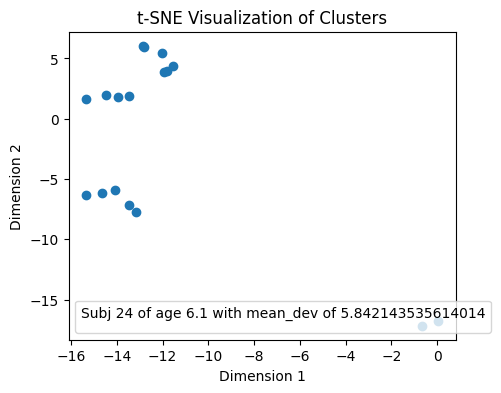

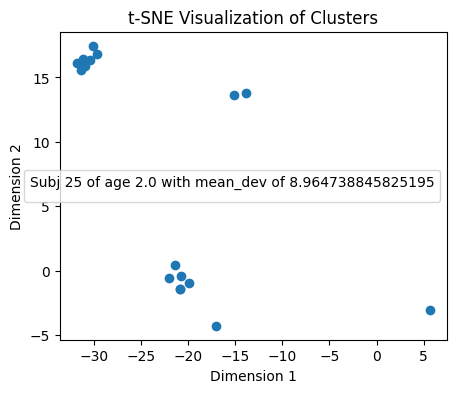

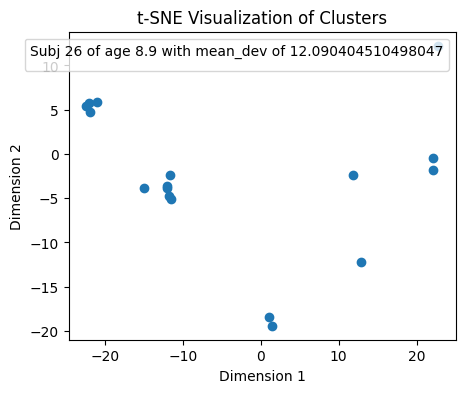

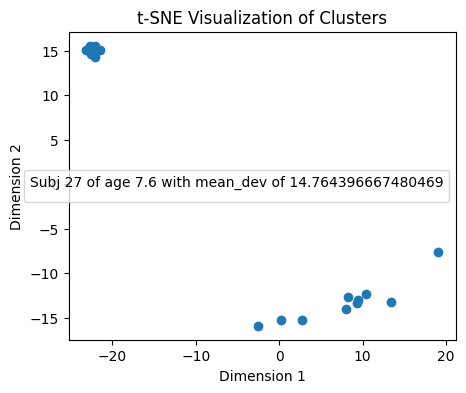

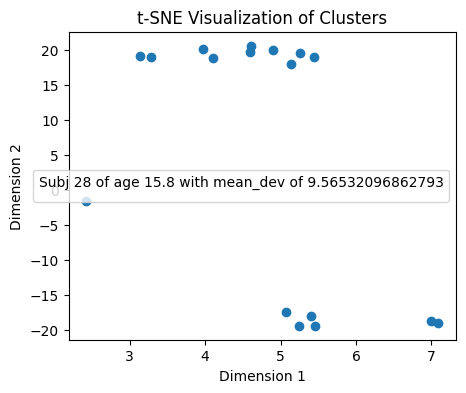

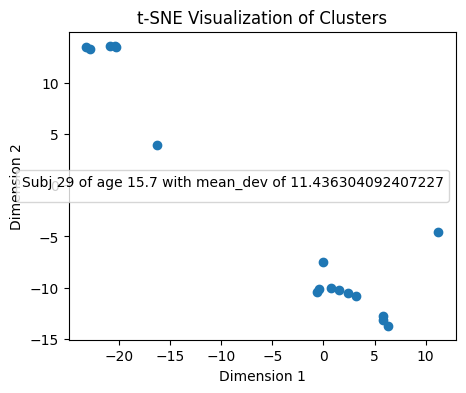

<Figure size 1000x800 with 0 Axes>

time: 53.8 s (started: 2023-10-16 03:04:39 +00:00)


In [ ]:
# @title Visualize Each Patient's Distribution with t-SNE
from sklearn.manifold import TSNE

ages = [5.6, 1.6, 4.8, 12.4, 6.6, 3.8, 4.9, 5.7, 2.2, 11.5, 4.7, 4.1, 0.7, 7.1, 12.1, 15.8, 11.6, 7.8, 1.5, 17.4, 0.8, 7.7, 15.3, 4.8, 6.1, 2.0, 8.9, 7.6, 15.8, 15.7]
mapping = []
all_means = []
for i in range(18):
  mapping.append((i * 18, i * 18 + 17))

mapping.append((324, 336))

for i in range(19, 30):
  mapping.append((337 + (i-19) * 18, (i-19) * 18 + 337 + 17))

# Assuming 'features' are your extracted features and 'cluster_assignments' are the cluster labels

tsne = TSNE(n_components=2, random_state=0)  # Use n_components=2 for 2D visualization
embedded_data = tsne.fit_transform(features)

# Create a scatter plot in 2D with cluster coloring
subj = 0
for map in mapping:
  plt.figure(figsize=(5, 4))
  scatter = plt.scatter(embedded_data[map[0]:map[1], 0], embedded_data[map[0]:map[1], 1])
  plt.title('t-SNE Visualization of Clusters')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  mean_dev = np.mean(np.std(embedded_data[map[0]:map[1]], axis = 0))
  all_means.append(mean_dev)

  # Add colorbar
  legend = plt.legend(*scatter.legend_elements(), title=f'Subj {subj} of age {ages[subj]} with mean_dev of {mean_dev}')
  # plt.show()
  subj += 1

plt.figure(figsize=(10,8))


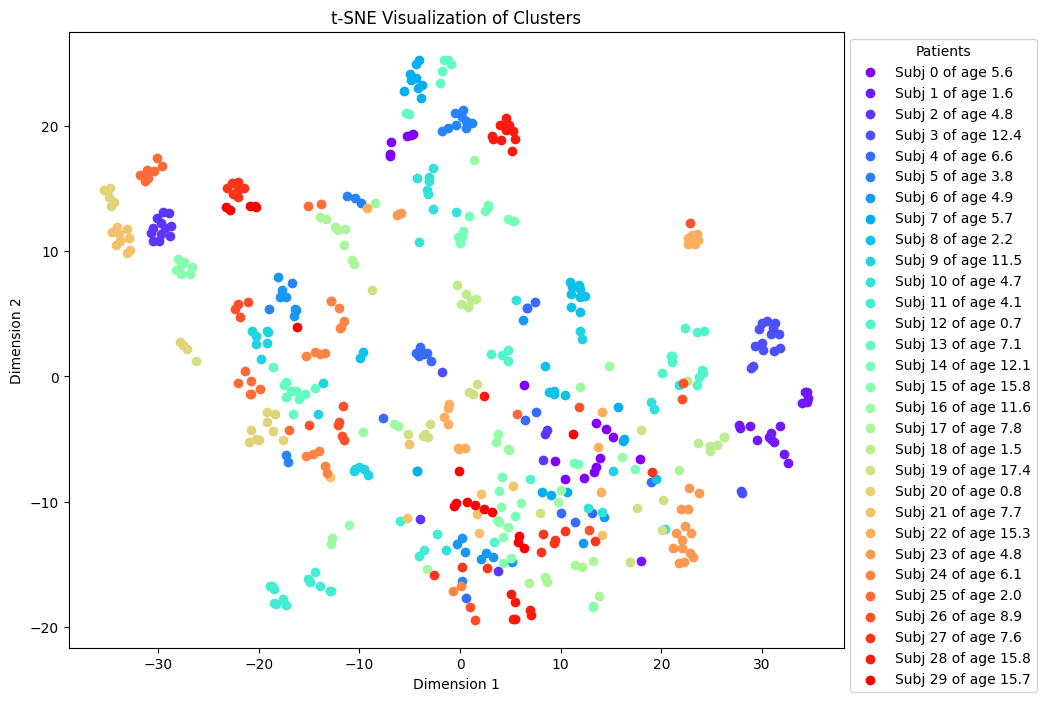

time: 944 ms (started: 2023-10-16 03:05:41 +00:00)


In [ ]:
# @title Visualize All Patients' Clusters

plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(mapping)))  # generates colors for each patient
legend_elements = []
for i, map_range in enumerate(mapping):
    plt.scatter(embedded_data[map_range[0]:map_range[1], 0], embedded_data[map_range[0]:map_range[1], 1], c=[colors[i]], label=f'Subj {i} of age {ages[i]}')
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'Subj {i} of age {ages[i]}'))


# legend
legend = plt.legend(title="Patients", loc='upper left', bbox_to_anchor=(1, 1))

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()


[0.16596954 8.13469837]


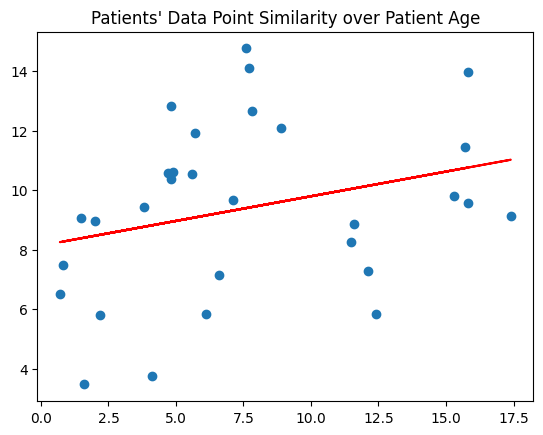

time: 233 ms (started: 2023-10-16 03:05:47 +00:00)


In [ ]:
# @title Graph of Subject Age over Data Point Similarity/Standard Deviation
coefs = np.polyfit(ages, all_means, 1)
print(coefs)
line = np.poly1d(coefs)
plt.scatter(ages, all_means)
plt.plot(ages, line(ages), color='red')
plt.title("Patients' Data Point Similarity over Patient Age")
plt.show()

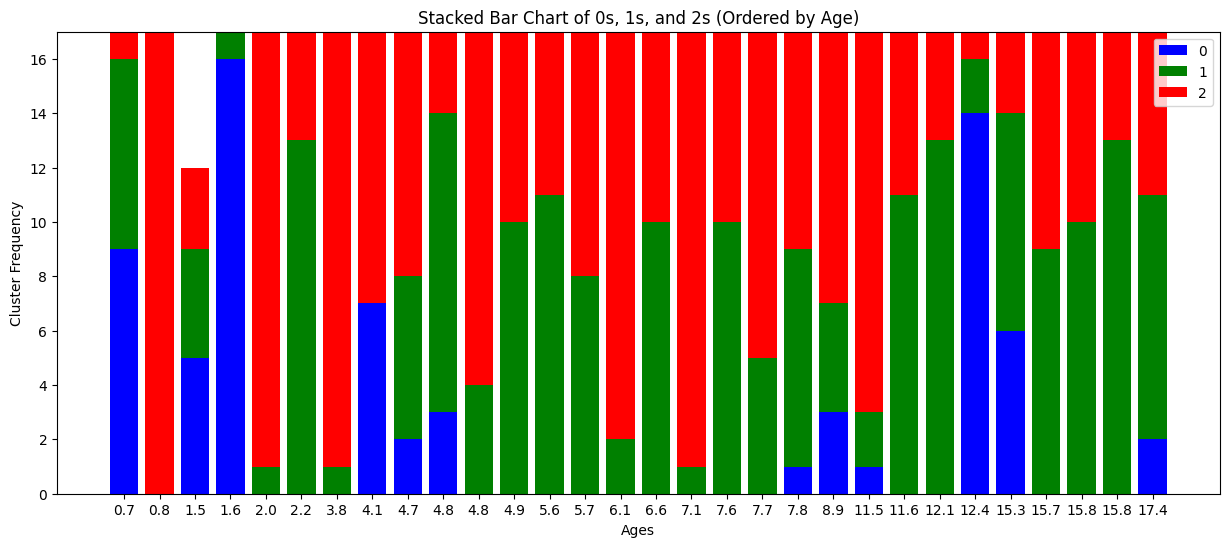

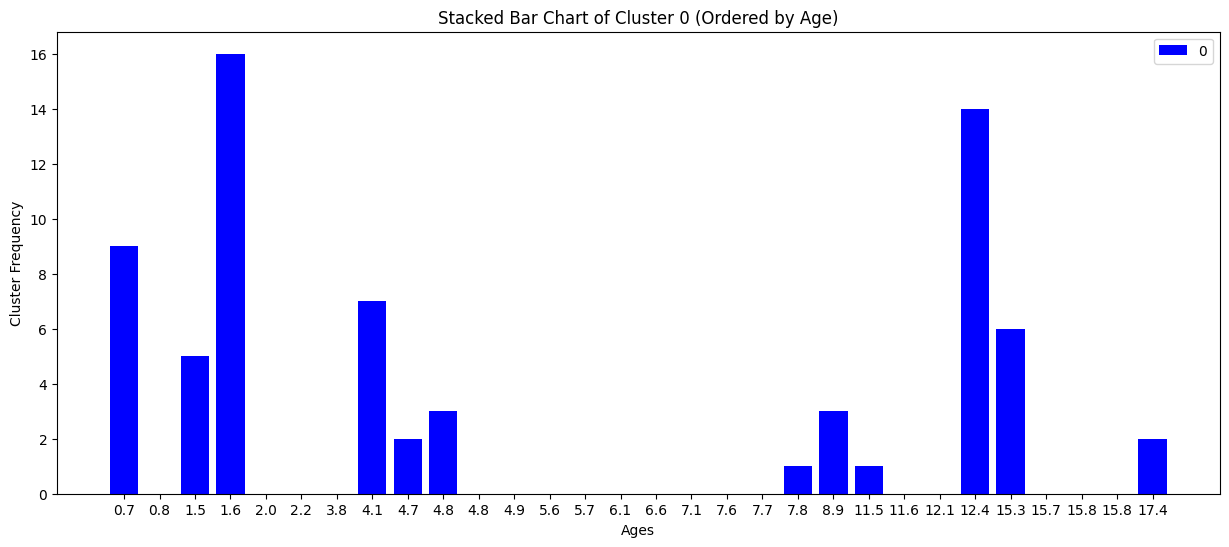

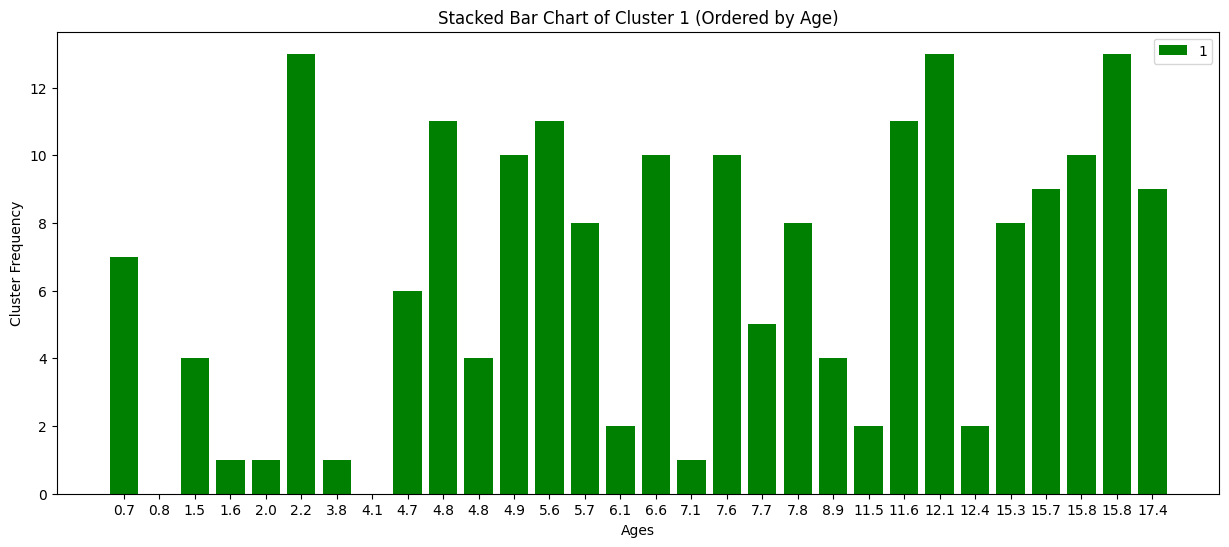

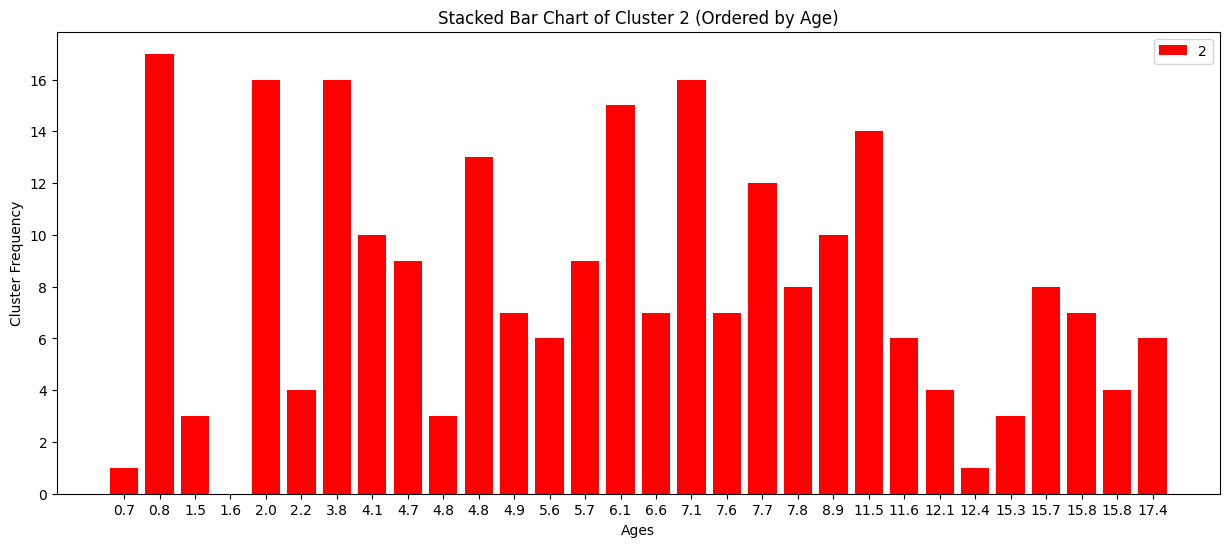

time: 1.82 s (started: 2023-10-16 03:06:01 +00:00)


In [ ]:
#@title Stacked Bar Charts
allss = []
for map in mapping:
  cluster_indices = cluster_assignments[map[0]:map[1]]
  allss.append(list(cluster_indices))

# Sort both lists based on ages
sorted_data = [x for _, x in sorted(zip(ages, allss))]
sorted_ages = sorted(ages)

# Initialize counters for each category (0, 1, 2)
count_0 = np.zeros(30)
count_1 = np.zeros(30)
count_2 = np.zeros(30)

# Iterate through each list in sorted_data and count occurrences
for i, lst in enumerate(sorted_data):
    count_0[i] = lst.count(0)
    count_1[i] = lst.count(1)
    count_2[i] = lst.count(2)

# Create the stacked bar chart
x = np.arange(len(sorted_data))  # X-axis values (bar positions)


# Create figure
plt.figure(figsize=(15, 6))

# Plot the bars
plt.bar(x, count_0, label='0', color='blue')
plt.bar(x, count_1, bottom=count_0, label='1', color='green')
plt.bar(x, count_2, bottom=count_0+count_1, label='2', color='red')

# Customize the chart
plt.xlabel('Ages')
plt.ylabel('Cluster Frequency')
plt.title('Stacked Bar Chart of 0s, 1s, and 2s (Ordered by Age)')
plt.xticks(x, [str(age) for age in sorted_ages])  # Set x-axis labels to ages
plt.legend()

# Show the chart
plt.show()

# Create figure
plt.figure(figsize=(15, 6))

# Plot the bars
plt.bar(x, count_0, label='0', color='blue')

# Customize the chart
plt.xlabel('Ages')
plt.ylabel('Cluster Frequency')
plt.title('Stacked Bar Chart of Cluster 0 (Ordered by Age)')
plt.xticks(x, [str(age) for age in sorted_ages])  # Set x-axis labels to ages
plt.legend()

# Show the chart
plt.show()

# Create figure
plt.figure(figsize=(15, 6))

# Plot the bars
plt.bar(x, count_1, label='1', color='green')

# Customize the chart
plt.xlabel('Ages')
plt.ylabel('Cluster Frequency')
plt.title('Stacked Bar Chart of Cluster 1 (Ordered by Age)')
plt.xticks(x, [str(age) for age in sorted_ages])  # Set x-axis labels to ages
plt.legend()

# Show the chart
plt.show()

# Create figure
plt.figure(figsize=(15, 6))

# Plot the bars
plt.bar(x, count_2, label='2', color='red')

# Customize the chart
plt.xlabel('Ages')
plt.ylabel('Cluster Frequency')
plt.title('Stacked Bar Chart of Cluster 2 (Ordered by Age)')
plt.xticks(x, [str(age) for age in sorted_ages])  # Set x-axis labels to ages
plt.legend()

# Show the chart
plt.show()

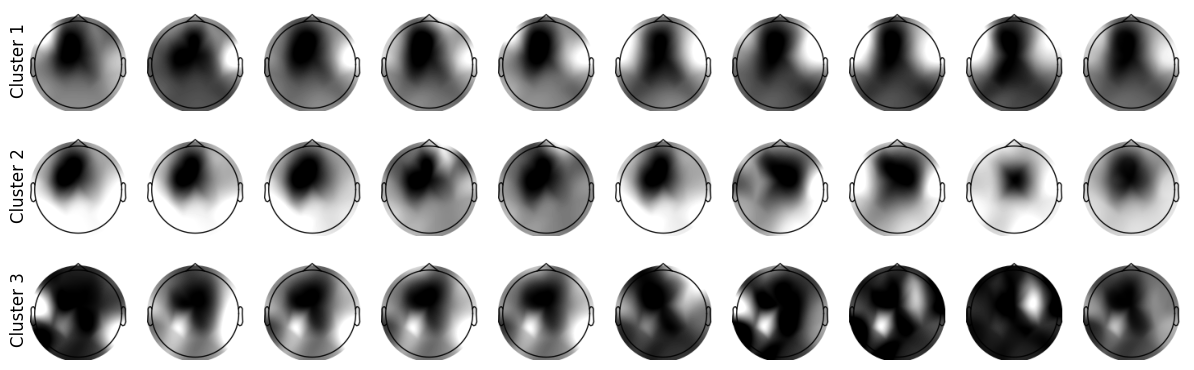

time: 770 ms (started: 2023-10-15 01:01:11 +00:00)


In [ ]:
# @title View 10 Images From Each Cluster
num_clusters = 3

fig, axes = plt.subplots(num_clusters, 10, figsize=(12, 4))
for cluster_num in range(num_clusters):
    images = []
    # find indices of data points in the current cluster
    cluster_indices = np.where(cluster_assignments == cluster_num)[0]
    # show 5 images from each cluster
    for i, idx in enumerate(cluster_indices[:10]):
        ax = axes[cluster_num, i]
        image = data[idx, :, :, 0]
        images.append(image)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
    average_image = np.mean(images, axis = 0)
    ax.imshow(average_image, cmap='gray')
    ax.axis('off')

# label each cluster
for r in range(num_clusters):
    ax = axes[r, 0]
    ax.text(-0.2, 0.5, f'Cluster {r + 1}', transform=ax.transAxes,
            rotation=90, va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

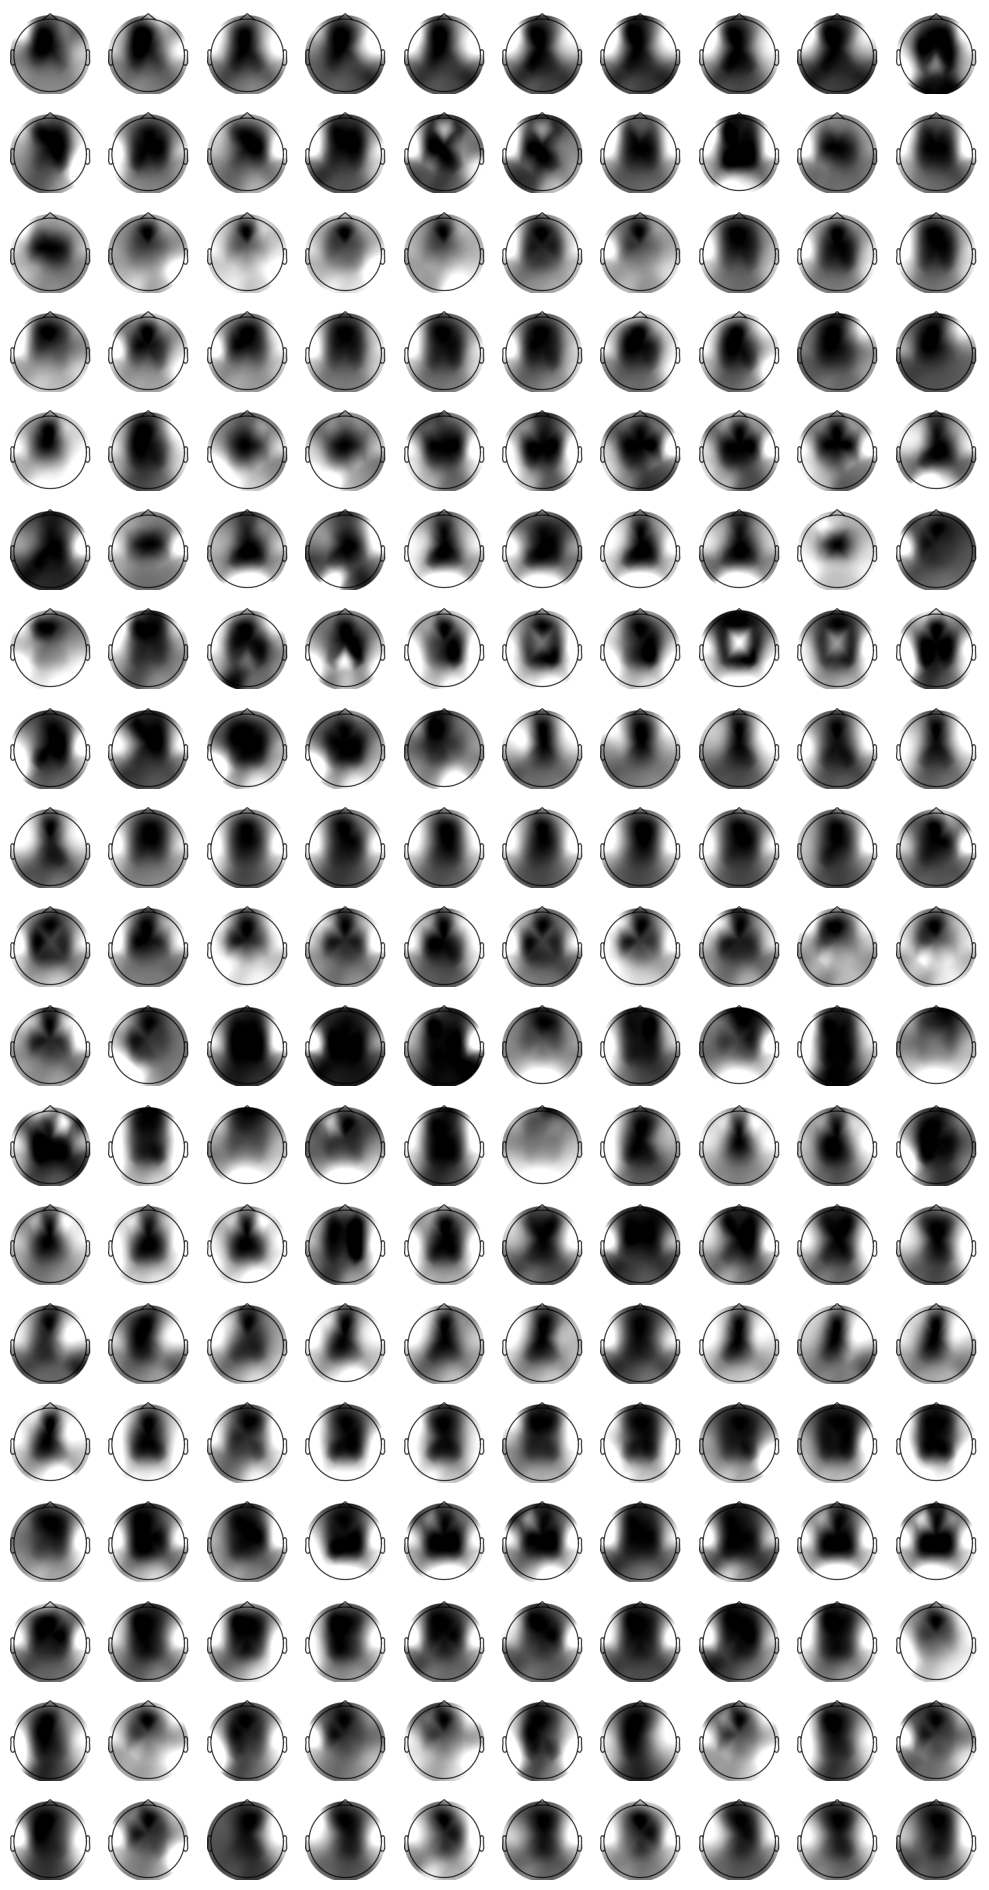

time: 8.37 s (started: 2023-09-24 22:09:10 +00:00)


In [ ]:
# @title All Images From Cluster 0
cluster_num = 0
cluster_indices = np.where(cluster_assignments == cluster_num)[0]
num_rows = int(cluster_indices.shape[0] / 10)
num_cols = 10


fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

# show 10 images from each cluster
for i, idx in enumerate(cluster_indices[:num_rows*num_cols]):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    image = data[idx, :, :, 0]
    ax.imshow(image, cmap='gray')
    ax.axis('off')


plt.tight_layout()
plt.show()

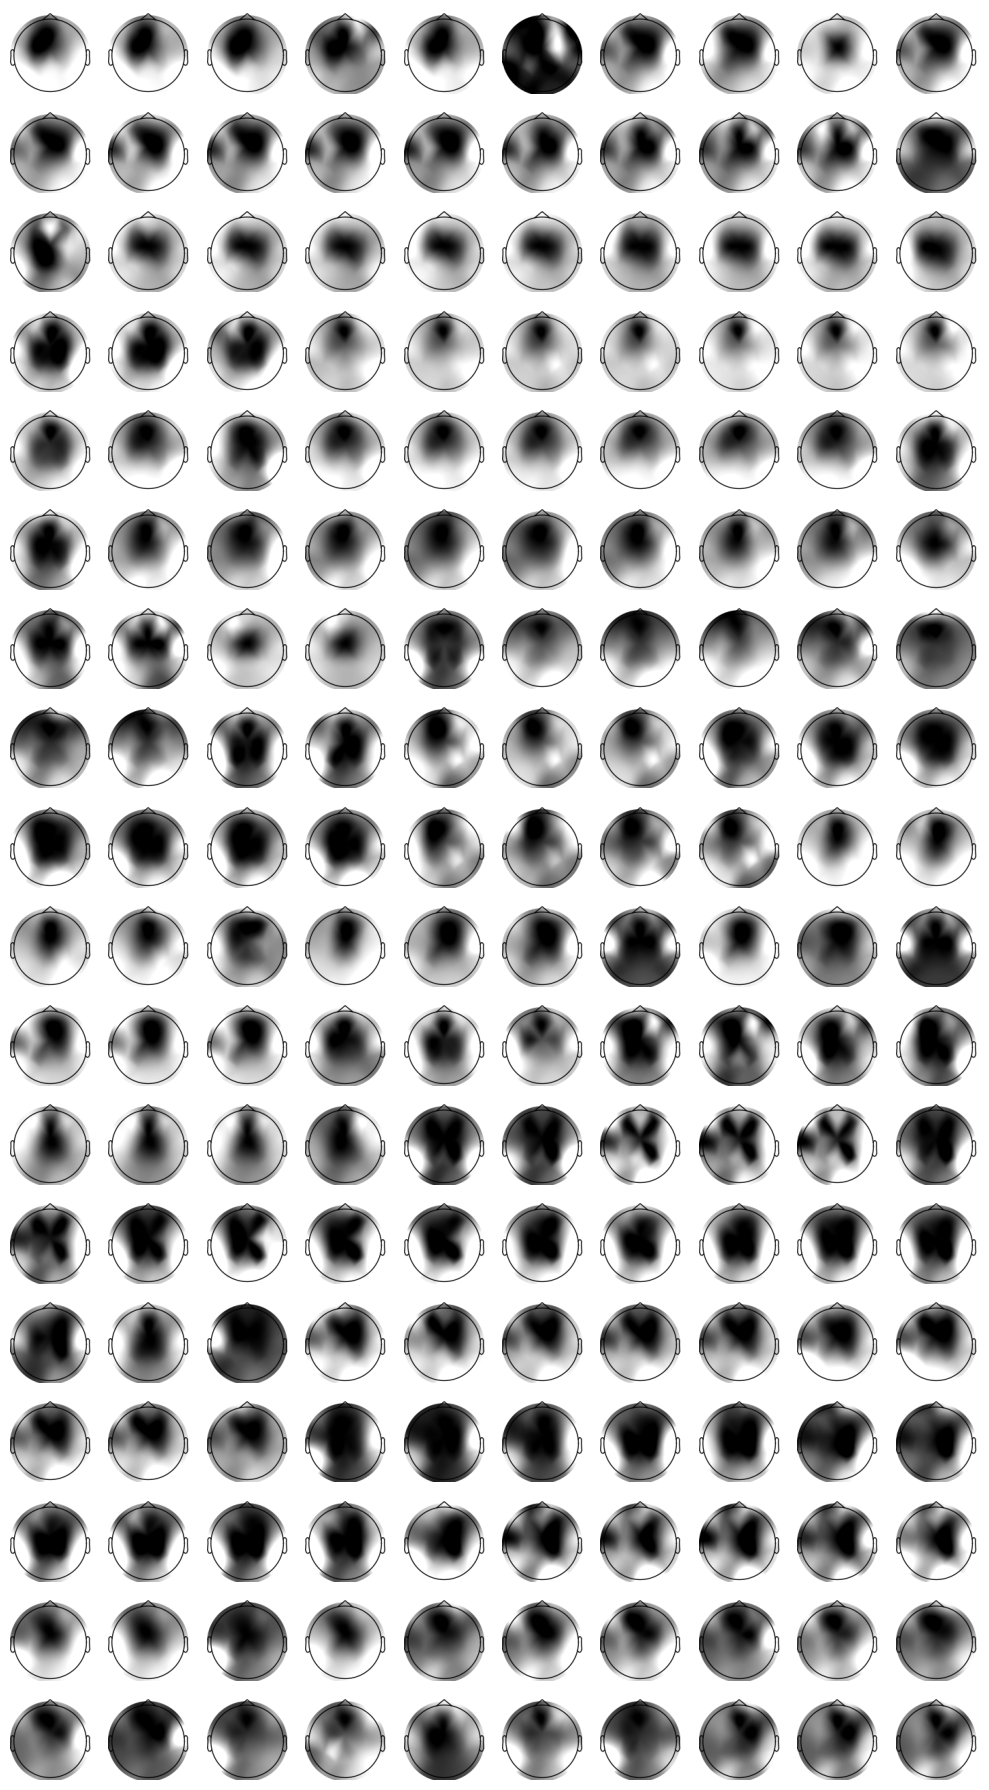

time: 7.91 s (started: 2023-09-24 22:09:50 +00:00)


In [ ]:
# @title All Images From Cluster 1
cluster_num = 1
cluster_indices = np.where(cluster_assignments == cluster_num)[0]
num_rows = int(cluster_indices.shape[0] / 10)
num_cols = 10


fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

# show 10 images from each cluster
for i, idx in enumerate(cluster_indices[:num_rows*num_cols]):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    image = data[idx, :, :, 0]
    ax.imshow(image, cmap='gray')
    ax.axis('off')


plt.tight_layout()
plt.show()

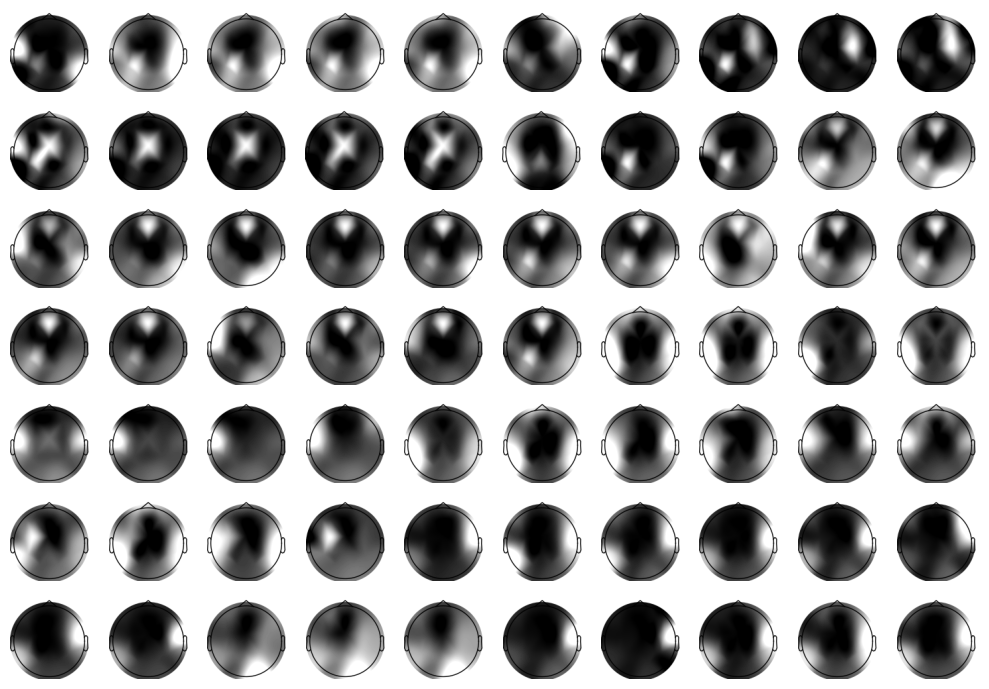

time: 3.46 s (started: 2023-08-30 00:18:11 +00:00)


In [ ]:
# @title All Images From Cluster 2
cluster_num = 2
cluster_indices = np.where(cluster_assignments == cluster_num)[0]
num_rows = int(cluster_indices.shape[0] / 10)
num_cols = 10


fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

# show 10 images from each cluster
for i, idx in enumerate(cluster_indices[:num_rows*num_cols]):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    image = data[idx, :, :, 0]
    ax.imshow(image, cmap='gray')
    ax.axis('off')


plt.tight_layout()
plt.show()

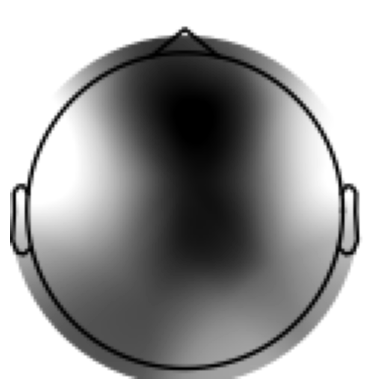

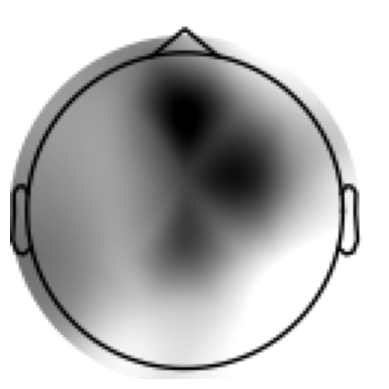

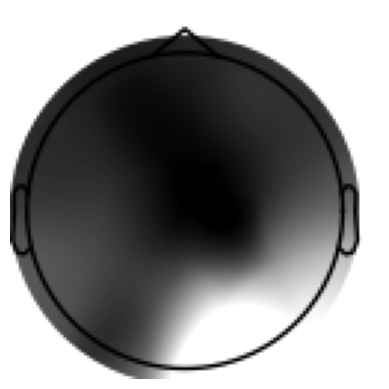

time: 634 ms (started: 2023-09-24 22:10:58 +00:00)


In [ ]:
# @title Average Image Per Cluster
num_clusters = 3

for cluster_num in range(num_clusters):
    images = []
    # find indices of data points in the current cluster
    cluster_indices = np.where(cluster_assignments == cluster_num)[0]
    all_indices_length = cluster_indices.shape[0]
    # show 5 images from each cluster
    for i, idx in enumerate(cluster_indices[:all_indices_length - 1]):
        image = data[idx, :, :, 0]
        images.append(image)
    average_image = np.mean(images, axis = 0)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

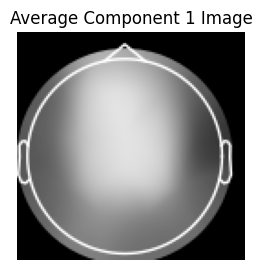

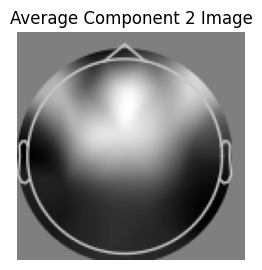

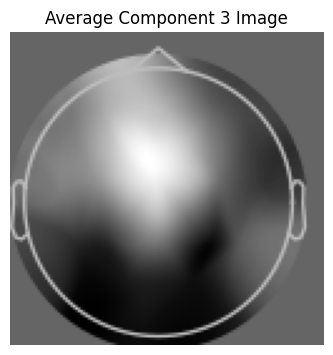

time: 671 ms (started: 2023-09-24 22:28:52 +00:00)


In [ ]:
#@title Image of Average PCA Component
import numpy as np
import matplotlib.pyplot as plt


# reshape
reshaped_data = np.moveaxis(reduced_data, 3, 0)  # shape will be (3, 535, 125, 125)

# find avg image
average_pca_images = np.mean(reshaped_data, axis=1)

# plot each pca component's avg image
for component_index, component_name in enumerate(["Component 1", "Component 2", "Component 3"]):
    component_average = average_pca_images[component_index]

    plt.figure(figsize = (10,8))
    plt.subplot(1, 3, component_index + 1)
    plt.imshow(component_average, cmap='gray')
    plt.title(f"Average {component_name} Image")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# @title Dimensionality Reduction With PCA
from sklearn.decomposition import PCA

# reshape data for pca input
num_samples, height, width, num_channels = data.shape
data_reshaped = data.reshape(num_samples * height * width, num_channels)


# initialize pca
pca = PCA(n_components=3)

# fit pca
reduced_data = np.empty((num_samples * height * width, 3))
reduced_data = pca.fit_transform(data_reshaped)
weights = pca.components_

# reshape lower-dimension data
reduced_data = reduced_data.reshape(num_samples, height, width, 3)
print(reduced_data.shape)

(535, 125, 125, 3)
time: 43 s (started: 2023-09-26 04:42:02 +00:00)
